# Lesson 3 Exercise 1: Three Queries Three Tables

### Walk through the basics of creating a table in Apache Cassandra, inserting rows of data, and doing a simple CQL query to validate the information. You will practice Denormalization, and the concept of 1 table per query, which is an encouraged practice with Apache Cassandra. 

### Remember, replace ##### with your answer.


Note: __Do not__ click the blue Preview button at the bottom

#### We will use a python wrapper/ python driver called cassandra to run the Apache Cassandra queries. This library should be preinstalled but in the future to install this library you can run this command in a notebook to install locally: 
! pip install cassandra-driver
#### More documentation can be found here:  https://datastax.github.io/python-driver/

#### Import Apache Cassandra python package

In [49]:
import cassandra

### Create a connection to the database

In [50]:
from cassandra.cluster import Cluster
try: 
    cluster = Cluster(['127.0.0.1']) #If you have a locally installed Apache Cassandra instance
    session = cluster.connect()
except Exception as e:
    print(e)

### Create a keyspace to work in

In [51]:
try:
    session.execute("""
    CREATE KEYSPACE IF NOT EXISTS udacity 
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }"""
)

except Exception as e:
    print(e)

#### Connect to our Keyspace. Compare this to how we had to create a new session in PostgreSQL.  

In [52]:
try:
    session.set_keyspace('udacity')
except Exception as e:
    print(e)

### Let's imagine we would like to start creating a Music Library of albums. 

### We want to ask 3 questions of the data
#### 1. Give every album in the music library that was released in a given year
`select * from music_library WHERE YEAR=1970`
#### 2. Give every album in the music library that was created by a given artist  
`select * from artist_library WHERE artist_name="The Beatles"`
#### 3. Give all the information from the music library about a given album
`select * from album_library WHERE album_name="Close To You"`


### Because we want to do three different queries, we will need different tables that partition the data differently.
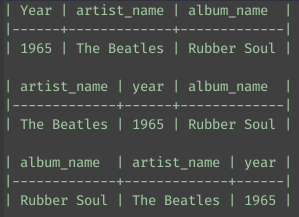

### Create the tables. 

In [53]:
def create_table(name, fields_query, primary_key):
    query = f"CREATE TABLE IF NOT EXISTS {name} ({fields_query}, PRIMARY KEY ({primary_key}))"
    try:
        session.execute(query)
    except Exception as e:
        print(e)

create_table("music_library", "year int, artist_name text, album_name text", "year, artist_name")
create_table("artist_library", "artist_name text, year int, album_name text", "artist_name, year") 
create_table("album_library", "album_name text, artist_name text, year int", "artist_name, album_name")

### Insert data into the tables

In [54]:
def insert_music_library(year, artist, album):
    try:
        session.execute("INSERT INTO music_library (year, artist_name, album_name) VALUES (%s, %s, %s)",
                       (year, artist, album))
    except Exception as e:
        print(e)
        
def insert_artist_library(artist, year, album):
    try:
        session.execute("INSERT INTO artist_library (artist_name, year, album_name) VALUES (%s, %s, %s)",
                       (artist, year, album))
    except Exception as e:
        print(e)
        
def insert_album_library(album, artist, year):
    try:
        session.execute("INSERT INTO album_library (album_name, artist_name, year) VALUES (%s, %s, %s)",
                       (album, artist, year))
    except Exception as e:
        print(e)
        
insert_music_library(1970, "The Beatles", "Let it Be")
insert_music_library(1965, "The Beatles", "Rubber Soul")
insert_music_library(1965, "The Who", "My Generation")
insert_music_library(1966, "The Monkees", "The Monkees")
insert_music_library(1970, "The Carpenters", "Close To You")
insert_artist_library("The Beatles", 1970, "Let it Be")
insert_artist_library("The Beatles", 1965, "Rubber Soul")
insert_artist_library("The Who", 1965, "My Generation")
insert_artist_library("The Monkees", 1966, "The Monkees")
insert_artist_library("The Carpenters", 1970, "Close To You")
insert_album_library("Let it Be", "The Beatles", 1970)
insert_album_library("Rubber Soul", "The Beatles", 1965)
insert_album_library("My Generation", "The Who", 1965)
insert_album_library("The Monkees", "The Monkees", 1966)
insert_album_library("Close To You", "The Carpenters", 1970)

This might have felt unnatural to insert duplicate data into the tables. If I just normalized these tables, I wouldn't have to have extra copies! While this is true, remember there are no `JOINS` in Apache Cassandra. For the benefit of high availibity and scalabity, denormalization must be how this is done. 


### Validate the Data Model

In [55]:
query = "select * from music_library WHERE YEAR=1970"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print (row.year, row.artist_name, row.album_name)

1970 The Beatles Let it Be
1970 The Carpenters Close To You


### Your output should be:
1970 The Beatles Let it Be<br>
1970 The Carpenters Close To You

### Validate the Data Model

In [56]:
query = "select * from album_library WHERE ARTIST_NAME='The Beatles'"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print (row.artist_name, row.album_name, row.year)

The Beatles Let it Be 1970
The Beatles Rubber Soul 1965


### Your output should be:
The Beatles Rubber Soul 1965 <br>
The Beatles Let it Be 1970 

### Validate the Data Model

In [57]:
query = "select * from artist_library WHERE artist_name='The Beatles'"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)

print([r for r in rows])
for row in rows:
    print (row.artist_name, row.year, row.album_name)

[Row(artist_name='The Beatles', year=1965, album_name='Rubber Soul'), Row(artist_name='The Beatles', year=1970, album_name='Let it Be')]


### Your output should be:
The Carpenters 1970 Close To You

### And finally close the session and cluster connection

In [58]:
session.shutdown()
cluster.shutdown()